<a href="https://colab.research.google.com/github/Raghuram-Veeramallu/Bayesian-Astrostat/blob/project1/Project%201/Project1_Group3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AST/STAT 5731 Project 1
## Research Synopsis 1

**Group: 3**  
Hari Veeramallu  
Nicholas Kruegler  
Daniel Warshofsky  
Jonah Koleske  

##Preamble

The dynamical evolution of a globular cluster (GC) can be impacted by the binary fraction, which is a measurement of the percent of the stars in a GC that are binary systems. Even a small binary fraction can have a large influence by cooling the cluster and pushing the system towards a higher mass concentration. This GC was chosen because a previous survey was carried out that found a sample of binary stars, and the detection rate bias parameter was determined for this galaxy, so we can adjust the recorded rate with the rate that would go undetected.

##1. Explain the Model

###Data Variables
1. $\theta$, the probability that the star system is binary.  
2. $\theta \in [0, 1]$  
3. $ x = 6, n = 66 $  
4. $ X \in \{0, 1\}^{n} $  
5. $ X | \theta  \in Binomial(n, \theta) $  
6. Given $ a > 0, b > 0 $, then $ \theta \sim Beta(a, b) $ (since beta is the conjugate prior of binomial).


###Likelihood Function
The sample space for observed data is a binary answer: either a star system is binary or it isn’t. Thus, we would expect it to follow a binomial distribution, which will be the model used in the statistical analysis.

For a binomial distribution, the expectation value is:
$E[X]=n\theta$

The variance is:
$Var[X]=n\theta (1-\theta)$

###Prior Distribution
A beta distribution is used for the prior, since the beta distribution is the conjugate prior for the binomial distribution. This makes the analytical calculation of the posterior possible, without relying on Monte Carlo computations. There is already previous knowledge about the binary fraction in the Milky Way, where this specific globular cluster NGC 5053 is found, so we have information for a prior.

For a beta distribution $Beta(a,b)$, the expectation value is:
$E[X] = \frac{a}{a+b}$

The variance is:
$Var[X] = \frac{ab}{(a+b)^2 (a+b+1)}$

###Posterior Distribution
Because the likelihood is a binomial distribution and we have assumed the prior to be a beta function, the posterior distribution can be found analytically.

Posterior is $\theta|x \sim Beta(a+x, n+b-x)$

The posterior expectation value will be:
$E[X] = \frac{a+x}{a+b+n}$


###Decisions about Data
The paper (https://arxiv.org/pdf/astro-ph/9607116.pdf) data from 77 stars NGC 5053 but only 66 had enough radial velocity measurements to determine if they are binary so analysis is restricted to only those stars. For one binary star (candadate ST) the authors were unsure of its membership to the cluster and counted it as being 0.5 of a binary, in our analysis we will count it as a full binary. Our analysis has $x=6$ where as the authors would have $x=5.5$.

###Possible Bias and Correction
The radial velocity method is only sensitive to the radial motion of the stars so systems that are face-on will not be detected, in the paper the authors preform a simulation to determinne how many systems they were likely to discover. After their anaylsis they determined that they would have discovered 29% of binaries.

###Prior Predictive Check

##Code and Computation Details

#### 1. Loading the data and Visualizing them

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from random import seed
import arviz as az
from google.colab import drive
az.style.use('arviz-darkgrid')

In [ ]:
# for local
# df = pd.read_table('./content/BinaryStarsNGC5053.tsv')

# for google drive (https://drive.google.com/drive/folders/1hatW5Gb4E7PtSTrPNSCLFlFZZkixh5F9?usp=sharing)
df = pd.read_table('/content/BinaryStarsNGC5053.tsv')

In [ ]:
df.sample(10)

,Star,Dist,VR,chi2,P(<chi2)
35,LY004,447.0,291.1,1.240,0.7434
46,SAI,32.8,288.7,0.811,0.6668
61,LY015,403.3,290.7,0.757,0.3842
0,S35,450.4,290.8,1.239,0.8760
54,S94,149.8,290.4,0.505,0.7768
9,S41,177.8,290.0,1.357,0.9289
2,S33,219.2,291.7,0.345,0.5572
32,S109,267.4,297.5,23.300,0.0003
31,LY7,251.1,286.6,,NaN
1,LY014,498.8,291.7,3.976,0.5528


**Data Description:**  
*Star* - Name of the star system.  
*Dist* - Radial distance of the star from the cluster  
*VR* - Weighted Mean Radial Velocity.  
*chi2* - Radial Velocity variability over the timespan of 3 years.  
*P(<chi2)* - Probability  

In [ ]:
df.describe()

,Dist,VR,chi2,P(<chi2)
count,77.000000,77.000000,66.000000,66.000000
mean,210.640260,291.355844,63.162848,0.478300
std,117.873282,2.339562,484.350757,0.288685
min,15.200000,286.600000,0.013000,0.000000
25%,125.100000,290.000000,0.614000,0.265450
50%,205.400000,291.000000,1.259000,0.498950
75%,275.800000,292.500000,2.747750,0.711400
max,513.900000,299.200000,3938.000000,0.942000


Within these stars the binary stars are defined as the ones having *P(<chi2)* $\lt 0.01$.  

In [ ]:
sin_obs = df[df['chi2'].isna()]
mul_obs = df[~df['chi2'].isna()]
bin_stars = mul_obs[mul_obs['P(<chi2)'] < 0.01]

In [ ]:
print(f'Total number of star systems present: {len(df)}')
print(f'Number of star systems having only a single Radial Velocity measurement: {len(sin_obs)}')
print(f'Number of star systems having multiple Radial Velocity measurements: {len(mul_obs)}')
print(f'Number of binary stars among the ones with multiple RV measurements: {len(bin_stars)}')

Total number of star systems present: 77
Number of star systems having only a single Radial Velocity measurement: 0
Number of star systems having multiple Radial Velocity measurements: 77
Number of binary stars among the ones with multiple RV measurements: 6


From the description we can see that only 66 out of the 77 can be used for binary search since the remaining 11 only have a single radial velocity measurement observed.

### 2. Visualizing the data

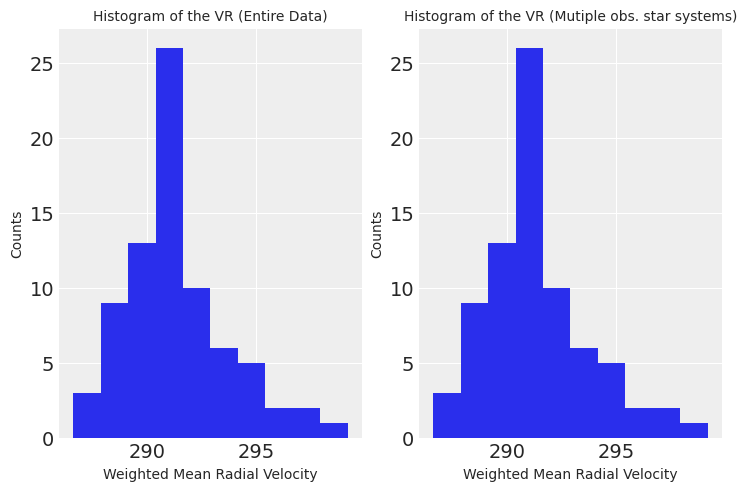

In [ ]:
# histogram of Weighted Mean Radial Velocities (VR)
fig, ax = plt.subplots(1, 2)
ax[0].hist(df['VR'])
ax[0].set_xlabel('Weighted Mean Radial Velocity', size = 10)
ax[0].set_ylabel('Counts', size = 10)
ax[0].set_title('Histogram of the VR (Entire Data)', size = 10)
ax[1].hist(mul_obs['VR'])
ax[1].set_xlabel('Weighted Mean Radial Velocity', size = 10)
ax[1].set_ylabel('Counts', size = 10)
ax[1].set_title('Histogram of the VR (Mutiple obs. star systems)', size = 10)

plt.show()

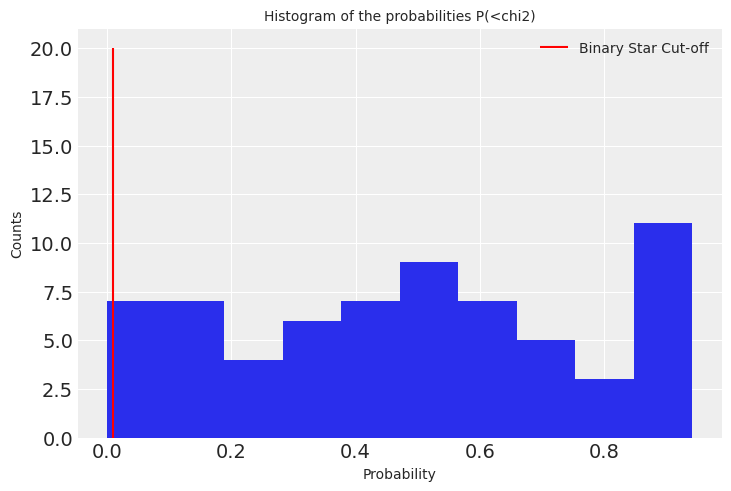

In [ ]:
plt.hist(mul_obs['P(<chi2)'])
plt.vlines(0.01, 0, 20, label = "Binary Star Cut-off", color='r')
plt.xlabel('Probability', size=10)
plt.ylabel('Counts', size=10)
plt.title('Histogram of the probabilities P(<chi2)', size=10)
plt.legend(prop={'size': 10})
plt.show()

### 3. Model

1. $\theta$, the probability that the star system is binary.  
2. $\theta \in [0, 1]$  
3. $ x = 6, n = 66 $  
4. $ \mathcal{X} \in \{0, 1\}^{n} $  
5. $ X | \theta  \in Binomial(n, \theta) $  
6. Given $ a > 0, b > 0 $, then $ \theta \sim Beta(a, b) $ (since beta is the conjugate prior of binomial).

Posterior is $\theta|x \sim Beta(a+x, n+b-x)$  

$E[X] = \frac{a}{a+b}$  

$Var[X] = \frac{ab}{(a+b)^2 (a+b+1)}$  

Assuming that the probability of a star system is binary is uniform, a = 1, b = 1

That would make the posterior $ => $ $ \theta | x \sim Beta(7, 61) $  
and $E[X] = \frac{1}{2} , Var[X] = \frac{1}{12} $

In [ ]:
a = 1
b = 1